# UUIDs in DataJoint

This chapter demonstrates how to use **Universally Unique Identifiers (UUIDs)** as primary keys in DataJoint tables. 

For the conceptual foundation on primary keys and when to use surrogate keys like UUIDs, see [Primary Keys](020-primary-key.md). That chapter covers:
- What primary keys are and why they matter
- Natural keys vs. surrogate keys
- When UUIDs are appropriate
- UUID types (UUID1, UUID3, UUID4, UUID5) and their characteristics
- Choosing the right UUID type for your use case

Here, we focus on **practical implementation** of UUIDs in DataJoint schemas.

## Quick Reference: UUID Types

- **UUID1**: Time-based, sortable (good for primary keys where ordering matters)
- **UUID4**: Random, anonymous (good for security tokens, session IDs)
- **UUID3/5**: Deterministic, hierarchical (good for content-addressable systems)

See [Primary Keys](020-primary-key.md) for detailed characteristics and use cases.

## Alternative Unique Identifier Systems

While UUIDs are the most common standardized unique identifier system, there are other alternatives that may be better suited for specific use cases:

### ULID (Universally Unique Lexicographically Sortable Identifier)

**ULID** provides a lexicographically sortable unique identifier that combines timestamp and randomness. Unlike UUIDs, ULIDs are guaranteed to be sortable by creation time.

**Key characteristics:**
- **48-bit timestamp** (millisecond precision) + **80-bit randomness**
- **Lexicographically sortable**: Can be sorted as strings to maintain chronological order
- **URL-safe**: Uses Crockford's Base32 encoding (no special characters)
- **Case-insensitive**: Designed for human readability
- **26 characters**: More compact than UUIDs (36 characters)

**Use cases:**
- Database primary keys where chronological sorting is important
- Log entries that need to maintain temporal order
- Distributed systems requiring sortable IDs without coordination
- When you need to sort by creation time without additional timestamp columns

**Example**: `01ARZ3NDEKTSV4RRFFQ69G5FAV`

**Resources:**
- [ULID Specification](https://github.com/ulid/spec)
- [ULID Generator/Calculator](https://zelark.github.io/nano-id-cc/)

### NANOID

**NANOID** is a tiny, URL-safe, unique string ID generator that uses a cryptographically strong random generator.

**Key characteristics:**
- **Configurable length**: Default is 21 characters (adjustable)
- **URL-safe**: Uses URL-safe characters (A-Za-z0-9_-)
- **Fast**: 4x faster than UUID
- **Smaller size**: 21 characters vs UUID's 36 characters
- **Collision-resistant**: Uses cryptographically strong random generator

**Use cases:**
- Short URLs or slugs
- Compact identifiers where size matters
- High-performance applications requiring fast ID generation
- User-facing identifiers where brevity improves UX

**Example**: `V1StGXR8_Z5jdHi6B-myT` (21 characters)

**Resources:**
- [NANOID GitHub](https://github.com/ai/nanoid)
- [NANOID Collision Calculator](https://zelark.github.io/nano-id-cc/)

### Choosing Between UUIDs, ULIDs, and NANOIDs

| Feature | UUID | ULID | NANOID |
|---------|------|------|--------|
| **Standard** | RFC 9562 | Community spec | Community spec |
| **Length** | 36 chars | 26 chars | 21 chars (default) |
| **Sortable** | UUID1/UUID6 only | ✅ Always | ❌ No |
| **Time-ordered** | UUID1/UUID6 only | ✅ Always | ❌ No |
| **URL-safe** | ✅ | ✅ | ✅ |
| **Database support** | ✅ Native in many | Limited | Limited |
| **Best for** | Standard compliance, interoperability | Sortable IDs, logs | Compact IDs, URLs |

**Note**: DataJoint natively supports UUIDs. For ULID or NANOID, you would store them as `varchar` or `char` or `binary` types.

## Python's UUID Module

Python provides the [UUID module](https://docs.python.org/3/library/uuid.html) as part of its standard library for generating UUIDs.

**Note**: UUIDs are standardized by [RFC 9562](https://www.rfc-editor.org/rfc/rfc9562.html) (which obsoletes RFC 4122). The Python `uuid` module implements the standard UUID formats defined in the specification.

In [2]:
import uuid

In [3]:
# Generate different types of UUIDs
uuid1_value = uuid.uuid1()  # Time-based, sortable
uuid4_value = uuid.uuid4()  # Random
print(f"UUID1: {uuid1_value}")
print(f"UUID4: {uuid4_value}")

UUID1: 3bb5d574-b8f1-11f0-966b-42531a4c8f38
UUID4: 70a060fa-99e2-4d37-bfa7-c4ffc799e2a1


In [4]:
uuid.uuid1()

UUID('3c315866-b8f1-11f0-966b-42531a4c8f38')

In [5]:
# UUID1 generates sequential UUIDs (notice the pattern)
[uuid.uuid1() for _ in range(5)]

[UUID('3ca03ede-b8f1-11f0-966b-42531a4c8f38'),
 UUID('3ca03f92-b8f1-11f0-966b-42531a4c8f38'),
 UUID('3ca03fb0-b8f1-11f0-966b-42531a4c8f38'),
 UUID('3ca03fc4-b8f1-11f0-966b-42531a4c8f38'),
 UUID('3ca03fd8-b8f1-11f0-966b-42531a4c8f38')]

In [6]:
# UUID4 generates random UUIDs (no pattern)
[uuid.uuid4() for _ in range(5)]

[UUID('7937d5cf-5568-4869-868d-6b0d40364360'),
 UUID('cdca9e61-e18c-46e5-966c-481a20f7fb53'),
 UUID('0154cafa-9200-406f-b03d-e5e8bf7f9023'),
 UUID('b2db8ca1-dcf3-4949-b433-f106b8fc32e2'),
 UUID('090380f6-a471-4251-85f9-75a3a907eaca')]

In [7]:
# UUID5 generates deterministic UUIDs from namespace + name
namespace = uuid.UUID('00000000-0000-0000-0000-000000000000')
topic = uuid.uuid5(namespace, 'Neuroscience')
subject = uuid.uuid5(topic, 'Habenula')
print(f"Topic UUID: {topic}")
print(f"Subject UUID: {subject}")
# Same inputs always produce same UUIDs
assert uuid.uuid5(namespace, 'Neuroscience') == topic

Topic UUID: 913e0174-a390-5c08-b50a-623690546dd5
Subject UUID: b5804c3f-57b1-54e3-8176-3b45aa443a97


## Using UUIDs in DataJoint Tables

DataJoint supports UUIDs as primary key types. When you declare a column as `uuid`, DataJoint automatically stores it as `BINARY(16)` in MySQL for efficient storage.

Let's create a simple example to demonstrate UUID usage in DataJoint:

In [14]:
import datajoint as dj

In [15]:
schema = dj.Schema('uuid')

In [16]:
@schema
class Message(dj.Manual):
    definition = """
    message_id : uuid  # internal message id
    ---
    message_body : varchar(1000) 
    """

In [17]:
print(Message.describe())

message_id           : uuid                         # internal message id
---
message_body         : varchar(1000)                



In [18]:
# For the curious: Internally, DataJoint represents uuids as BINARY(16) 
Message.heading['message_id'].sql

'`message_id` binary(16) NOT NULL COMMENT ":uuid:internal message id"'

In [19]:
Message.insert1((uuid.uuid1(), 'Hello, world!'))
Message.insert1((uuid.uuid1(), 'Cogito ergo sum'))

In [20]:
Message()

message_id internal message id,message_body
5d4e0c56-b8f1-11f0-966b-42531a4c8f38,"Hello, world!"
5d4eba5c-b8f1-11f0-966b-42531a4c8f38,Cogito ergo sum


In [21]:
Message.insert1((uuid.uuid1(), 'I will be back'))
Message.insert1((uuid.uuid1(), 'Must destroy humans.'))

In [22]:
b = uuid.uuid4().bytes
b

b'\x8c~\xa5\x83\x9a5C\x90\xaf6%\x87+{#\x1e'

In [23]:
uuid.UUID(bytes=b)

UUID('8c7ea583-9a35-4390-af36-25872b7b231e')

In [24]:
Message()

message_id internal message id,message_body
5d4e0c56-b8f1-11f0-966b-42531a4c8f38,"Hello, world!"
5d4eba5c-b8f1-11f0-966b-42531a4c8f38,Cogito ergo sum
5dce3d18-b8f1-11f0-966b-42531a4c8f38,I will be back
5dced91c-b8f1-11f0-966b-42531a4c8f38,Must destroy humans.


In [25]:
Message.insert1((uuid.uuid4(), 'Hasta la vista baby'))

In [26]:
Message()

message_id internal message id,message_body
5d4e0c56-b8f1-11f0-966b-42531a4c8f38,"Hello, world!"
5d4eba5c-b8f1-11f0-966b-42531a4c8f38,Cogito ergo sum
5dce3d18-b8f1-11f0-966b-42531a4c8f38,I will be back
5dced91c-b8f1-11f0-966b-42531a4c8f38,Must destroy humans.
9ca5cb3d-c989-4f0f-adf8-8eb0193f4bcc,Hasta la vista baby


In [27]:
@schema
class Comment(dj.Manual):
    definition = """
    comment_id : uuid
    --- 
    -> Message
    comment_body : varchar(1000)
    """

In [28]:
# For the curious: This is how the table was declared in SQL
print(schema.connection.query('show create table `uuid`.`comment`').fetchall()[0][1])

CREATE TABLE `comment` (
  `comment_id` binary(16) NOT NULL COMMENT ':uuid:',
  `message_id` binary(16) NOT NULL COMMENT ':uuid:internal message id',
  `comment_body` varchar(1000) NOT NULL,
  PRIMARY KEY (`comment_id`),
  KEY `message_id` (`message_id`),
  CONSTRAINT `comment_ibfk_1` FOREIGN KEY (`message_id`) REFERENCES `message` (`message_id`) ON DELETE RESTRICT ON UPDATE CASCADE
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_0900_ai_ci


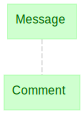

In [29]:
dj.Diagram(schema)

In [30]:
keys = Message.fetch('KEY')

In [31]:
keys

[{'message_id': UUID('5d4e0c56-b8f1-11f0-966b-42531a4c8f38')},
 {'message_id': UUID('5d4eba5c-b8f1-11f0-966b-42531a4c8f38')},
 {'message_id': UUID('5dce3d18-b8f1-11f0-966b-42531a4c8f38')},
 {'message_id': UUID('5dced91c-b8f1-11f0-966b-42531a4c8f38')},
 {'message_id': UUID('9ca5cb3d-c989-4f0f-adf8-8eb0193f4bcc')}]

In [32]:
Comment.insert1(dict(keys[0], comment_id=uuid.uuid1(), comment_body="thank you"))

In [33]:
Message * Comment

message_id internal message id,comment_id,message_body,comment_body
5d4e0c56-b8f1-11f0-966b-42531a4c8f38,62370f06-b8f1-11f0-966b-42531a4c8f38,"Hello, world!",thank you


In [34]:
Message * Comment & keys[0]

message_id internal message id,comment_id,message_body,comment_body
5d4e0c56-b8f1-11f0-966b-42531a4c8f38,62370f06-b8f1-11f0-966b-42531a4c8f38,"Hello, world!",thank you


In [35]:
Message & keys[1:4]

message_id internal message id,message_body
5d4eba5c-b8f1-11f0-966b-42531a4c8f38,Cogito ergo sum
5dce3d18-b8f1-11f0-966b-42531a4c8f38,I will be back
5dced91c-b8f1-11f0-966b-42531a4c8f38,Must destroy humans.


In [36]:
Comment.insert1(dict(keys[1], comment_id=uuid.uuid1(), comment_body="thank you"))

In [37]:
Comment()

comment_id,message_id internal message id,comment_body
62370f06-b8f1-11f0-966b-42531a4c8f38,5d4e0c56-b8f1-11f0-966b-42531a4c8f38,thank you
63ad8eaa-b8f1-11f0-966b-42531a4c8f38,5d4eba5c-b8f1-11f0-966b-42531a4c8f38,thank you


In [38]:
Message & Comment

message_id internal message id,message_body
5d4e0c56-b8f1-11f0-966b-42531a4c8f38,"Hello, world!"
5d4eba5c-b8f1-11f0-966b-42531a4c8f38,Cogito ergo sum


In [39]:
Message - Comment

message_id internal message id,message_body
5dce3d18-b8f1-11f0-966b-42531a4c8f38,I will be back
5dced91c-b8f1-11f0-966b-42531a4c8f38,Must destroy humans.
9ca5cb3d-c989-4f0f-adf8-8eb0193f4bcc,Hasta la vista baby


In [40]:
Message * Comment

message_id internal message id,comment_id,message_body,comment_body
5d4e0c56-b8f1-11f0-966b-42531a4c8f38,62370f06-b8f1-11f0-966b-42531a4c8f38,"Hello, world!",thank you
5d4eba5c-b8f1-11f0-966b-42531a4c8f38,63ad8eaa-b8f1-11f0-966b-42531a4c8f38,Cogito ergo sum,thank you
